# Modèle de classification de 4 espèces de poissons

Le Modèle présenté ci-dessous à été entrainé sur un petit dataset récolté pendant le Brest Ocean Hackathon 6.

La faible dimension du dataset n'a pas permis d'obtenir un modèle réellement performant, cependant, il est possible de repartir de la base ci-dessous en développant le jeu de données.

Plusieurs modèles ont été testés pendant le hackathon. Le plus performant, proposé ci-dessous, est basé sur la technique du transfert d'apprentissage, qui consiste à réutiliser les poids d'un modèle (ici Xception) préentrainé sur un dataset généraliste (ici imagenet).



In [42]:
import numpy as np
import os
import cv2
import random

import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, confusion_matrix

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, regularizers, initializers
from keras.layers import Conv2D, Dense, MaxPooling2D, Flatten, Dropout, BatchNormalization, GaussianNoise, GlobalAveragePooling2D
from keras import Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

tf.random.set_seed(844974439716727053)
random.seed(844974439716727053)

In [43]:
DATA_PATH = "./classification_data/"

folders_names = os.listdir(DATA_PATH)
folders_names.sort()

In [44]:
print(folders_names)

['Acanthurus_olivaceus', 'Carcharhinus_amblyrhynchos', 'Gymnocranius_euanus', 'Parupeneus_barberinous']


In [45]:
LABELS={}
for i, folder in enumerate(folders_names):
    print(f"{folder} ({i}): {len(os.listdir(DATA_PATH+folder))} images")
    LABELS[i]=folder

Acanthurus_olivaceus (0): 40 images
Carcharhinus_amblyrhynchos (1): 43 images
Gymnocranius_euanus (2): 44 images
Parupeneus_barberinous (3): 44 images


In [46]:
X_train, Y_train =list(), list()
X_val, Y_val =list(), list()

for i, folder in enumerate(folders_names):
    img_keps = os.listdir(DATA_PATH+folder)
    valsplit=len(img_keps)//4
    aa, bb = len(X_train), len(X_val)
    for img in img_keps[:valsplit*3]:
        if cv2.imread(DATA_PATH+folder+"/"+img) is not None:
            X_train.append(cv2.cvtColor(cv2.imread(DATA_PATH+folder+"/"+img), cv2.COLOR_BGR2RGB))
            Y_train.append(i)
    for img in img_keps[valsplit*3:]:
        if cv2.imread(DATA_PATH+folder+"/"+img) is not None:
            X_val.append(cv2.cvtColor(cv2.imread(DATA_PATH+folder+"/"+img), cv2.COLOR_BGR2RGB))
            Y_val.append(i)
    print(LABELS[i], ":", len(X_train)-aa, len(X_val)-bb)
print("\n   Total: \n\t - train:", len(X_train), "\n\t - val:", len(X_val))


Acanthurus_olivaceus : 30 10
Carcharhinus_amblyrhynchos : 30 13
Gymnocranius_euanus : 33 11
Parupeneus_barberinous : 33 11

   Total: 
	 - train: 126 
	 - val: 45


In [47]:
index = np.random.permutation([i for i in range(len(X_train))]) 
X_train = np.asarray(X_train, dtype=object)[index]
Y_train = np.asarray(Y_train)[index]

index2 = np.random.permutation([i for i in range(len(X_val))]) 
X_val = np.asarray(X_train, dtype=object)[index2]
Y_val = np.asarray(Y_train)[index2]

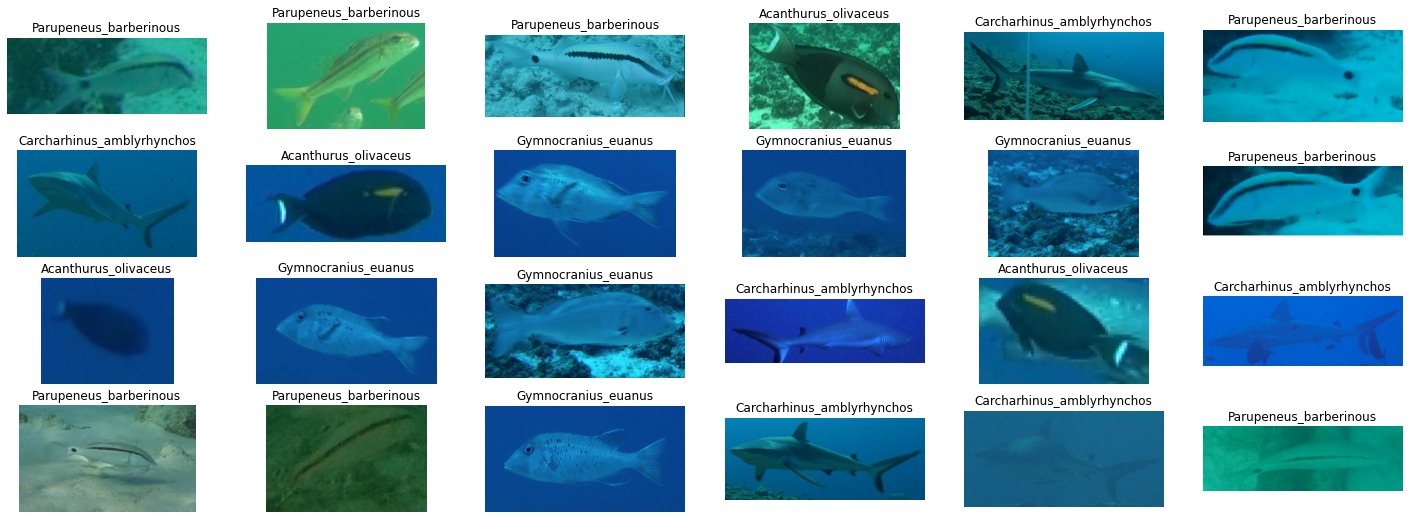

In [48]:
plt.figure(figsize=(25,9))
for i in range(24):
    plt.subplot(4,6,i+1)
    plt.imshow(X_train[i])
    plt.title(LABELS[Y_train[i]])
    plt.axis('off')
plt.show()

In [49]:
def resize_and_pad(im):
    desired_size = 150
    old_size = im.shape[:2]

    ratio = float(desired_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])

    im = cv2.resize(im, (new_size[1], new_size[0]), interpolation =cv2.INTER_CUBIC)

    delta_w = desired_size - new_size[1]
    delta_h = desired_size - new_size[0]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)

    new_im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT)

    return new_im

def resize_fish(im):
    desired_size = 150
    new_im = cv2.resize(im, (desired_size, desired_size), interpolation=cv2.INTER_LINEAR)

    return new_im

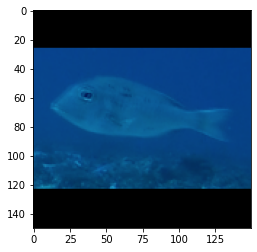

In [50]:
plt.imshow(resize_and_pad(X_train[9]))

In [51]:
X_train=np.asarray([resize_fish(xx) for xx in X_train])
X_val=np.asarray([resize_fish(xx) for xx in X_val])

In [52]:
Y_train = to_categorical(Y_train, num_classes=4)
Y_val = to_categorical(Y_val, num_classes=4)

In [53]:
print(X_train.shape)
print(Y_train.shape)

(126, 150, 150, 3)
(126, 4)


In [ ]:
base_model = tf.keras.applications.Xception(
    weights='imagenet',
    input_shape=(150, 150, 3),
    include_top=False) 
base_model.trainable = False

inputs = tf.keras.Input(shape=(150, 150, 3))

scale_layer = tf.keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(inputs)

x = base_model(x, training=False)
x = GlobalAveragePooling2D()(x)

outputs = Dense(4, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

In [34]:
BATCH_SIZE = 8
EPOCHS = 100

train_datagen = ImageDataGenerator(
        vertical_flip=True,
        width_shift_range=0.2,
        height_shift_range=0.2)

val_datagen = ImageDataGenerator(
        rotation_range=40,
        vertical_flip=True)

train_generator = train_datagen.flow(
        X_train, Y_train, 
        batch_size=BATCH_SIZE)

validation_generator = val_datagen.flow(
        X_val, Y_val, 
        batch_size=BATCH_SIZE)

In [ ]:
EPOCHS=50
lr_reducer = ReduceLROnPlateau(factor=0.1, patience=18, verbose=1, min_lr=0.1e-7)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.05, patience=9, verbose=1, mode='auto')

model.compile(optimizer = optimizers.Adamax(learning_rate=0.001, 
                                          beta_1=0.6, 
                                          beta_2=0.8,
                                          epsilon=1e-7), 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

history = model.fit(X_train, Y_train,
                     steps_per_epoch = len(X_train) // BATCH_SIZE,
                     validation_data = (X_val, Y_val),
                     validation_steps = len(X_val) // BATCH_SIZE //2,
                     callbacks = [lr_reducer, early_stop], 
                     epochs = EPOCHS)

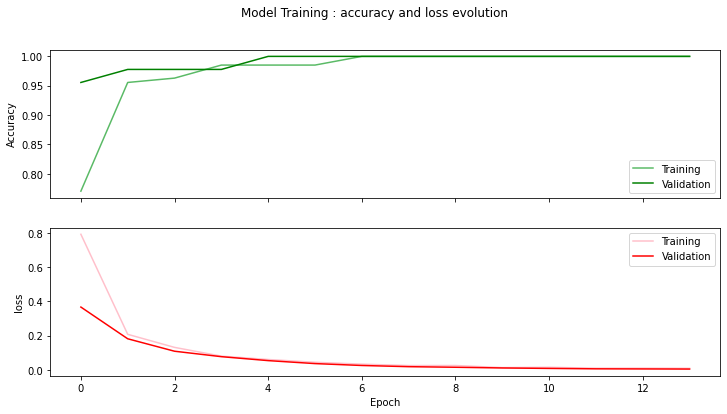

In [37]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

x = list(range(len(loss)))

fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(12,6))
fig.suptitle('Model Training : accuracy and loss evolution')
ax1.plot(x, accuracy, color='#5aba66')
ax1.plot(x, val_accuracy, color='green')
ax1.set_ylabel('Accuracy')
ax1.legend(['Training', 'Validation'], loc='lower right')
ax2.plot(x, loss,  color='pink')
ax2.plot(x, val_loss,  color='red')
ax2.set_ylabel('loss')
ax2.set_xlabel('Epoch')
ax2.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [92]:
model = tf.keras.models.load_model('mymodel')

In [ ]:
base_model.trainable = True

BATCH_SIZE=8

model.compile(optimizer=optimizers.Adam(learning_rate=0.0001, 
                                          beta_1=0.8, 
                                          beta_2=0.9,
                                          epsilon=1e-7), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

history2 = model.fit(train_generator,
                     steps_per_epoch=len(X_train) // BATCH_SIZE,
                     validation_data=validation_generator,
                     validation_steps=len(X_val) // BATCH_SIZE //2,
                     callbacks=[lr_reducer], 
                     epochs=EPOCHS)

In [ ]:
model.save('mymodel2')

<hr>
<hr>

## Model testing

In [70]:
model= tf.keras.models.load_model('mymodel2')

In [98]:
LABELS = {0:'Acanthurus olivaceus',
          1:'Carcharhinus amblyrhynchos', 
          2:'Gymnocranius euanus', 
          3:'Parupeneus barberinus'}

In [99]:
def read_image(path):
    img=cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
    img=resize_and_pad(img)
    return img

def make_prediction(img):
    img=np.expand_dims(img,0)
    pred=model.predict(img)
    pp=np.argmax(pred)
    proba=np.max(pred)

    return LABELS[pp], proba

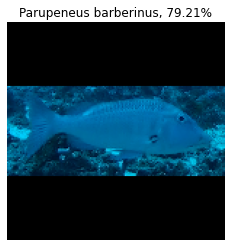

In [100]:
image= read_image('/test/test1.png')
species, proba = make_prediction(image)
plt.imshow(image)
plt.title(f'{species}, {np.round(proba*100,2)}%')
plt.axis("off")
plt.show()

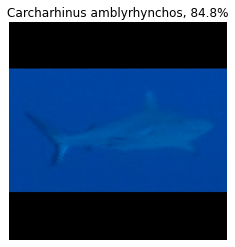

In [101]:
image= read_image('/test/test2.png')
species, proba = make_prediction(image)
plt.imshow(image)
plt.title(f'{species}, {np.round(proba*100, 2)}%')
plt.axis("off")
plt.show()

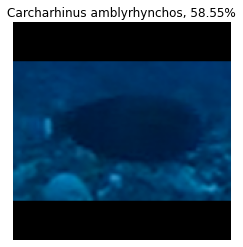

In [78]:
image= read_image('/test/test3.png')
species, proba = make_prediction(image)
plt.imshow(image)
plt.title(f'{species}, {np.round(proba*100,2)}%')
plt.axis("off")
plt.show()

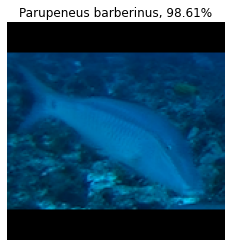

In [102]:
image= read_image('/test/test4.png')
species, proba = make_prediction(image)
plt.imshow(image)
plt.title(f'{species}, {np.round(proba*100,2)}%')
plt.axis("off")
plt.show()